<a href="https://colab.research.google.com/github/moh53/Graduation-Project-FMS/blob/NN-models/3GB/ResNet_3GB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
print("jj")

In [ ]:
from google.colab import files
files.upload()

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.09G/3.10G [00:52<00:00, 56.0MB/s]
100% 3.10G/3.10G [00:52<00:00, 63.2MB/s]


In [ ]:
from zipfile import ZipFile
file_name = "breast-histopathology-images.zip"
with ZipFile(file_name, 'r')as zip:
  data= zip.extractall()
  print('Done')

Done


In [ ]:
# Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import tarfile
from tqdm.notebook import tqdm
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import pandas as pd
import time
#from torchviz import make_dot
#import hiddenlayer as hl

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision import transforms
import torchvision.models as models

In [ ]:
# Load all image data
data_dir = '/content/'
folder_name = "IDC_regular_ps50_idx5"
image_folders = os.path.join(data_dir, folder_name)

transform = transforms.Compose([transforms.Resize((50, 50)), transforms.ToTensor()])
images = []
for file in os.listdir(image_folders):
    images.append(ImageFolder(os.path.join(image_folders, file), transform=transform))
datasets = torch.utils.data.ConcatDataset(images)

In [ ]:
data_dir = '/content/IDC_regular_ps50_idx5'

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [ ]:
# Prepare data for training, validation and test
random_seed = 42
torch.manual_seed(random_seed)

test_size = 38000
train_size = len(datasets) - test_size
train_ds, test_ds = random_split(datasets, [train_size, test_size])

val_size = 38000
train_size = len(train_ds) - val_size
train_ds, val_ds = random_split(train_ds, [train_size, val_size])

len(train_ds), len(val_ds), len(test_ds)

(201524, 38000, 38000)

In [ ]:
train_loader = DataLoader(train_ds, batch_size=400, shuffle=True, num_workers=4, pin_memory=True)
val_data = DataLoader(val_ds, batch_size=400, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=400, shuffle=True, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
model = models.resnet18(pretrained = True) 
model 

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
num_ftrs = model.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model.fc = nn.Linear(num_ftrs, 2)


In [ ]:
model = model.cuda() 
#optimizer= torch.optim.Adam(model.classifier.parameters()) 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterian= nn.NLLLoss() 
list_train_loss=[] 
list_test_loss=[] 
 
for epoch in range(2): 
    train_loss= 0 
    test_loss= 0 
    for bat,(img,label) in enumerate(train_loader): 
        # moving batch and labels to gpu 
        img = img.to('cuda:0') 
        label = label.to('cuda:0') 
        model.train() 
        optimizer.zero_grad() 
 
        output = model(img) 
        loss = criterian(output,label) 
        loss.backward() 
        optimizer.step() 
        train_loss = train_loss+loss.item() 
 
    accuracy=0 
    for bat,(img,label) in enumerate(test_loader): 
        img = img.to('cuda:0') 
        label = label.to('cuda:0') 
        model.eval() 
        logps= model(img) 
        loss = criterian(logps,label) 
        test_loss+= loss.item() 
        ps=torch.exp(logps) 
        top_ps,top_class=ps.topk(1,dim=1) 
        equality=top_class == label.view(*top_class.shape) 
        accuracy +=torch.mean(equality.type(torch.FloatTensor)).item() 
 
    list_train_loss.append(train_loss/20) 
    list_test_loss.append(test_loss/20) 
    print('epoch: ',epoch,' train_loss: ',train_loss/20,' test_loss: ',test_loss/20,' accuracy: ', accuracy/len(test_loader)) 

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()


In [ ]:
model = model.cuda() 
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterian=  nn.CrossEntropyLoss() 
losses = list() 
for epoch in range(5):
  train_loss= 0 
  test_loss= 0 
  for bat,(img,label) in enumerate(train_loader): 
        # moving batch and labels to gpu 
        img = img.to('cuda:0') 
        label = label.to('cuda:0') 
        model.train() 
        optimizer.zero_grad() 
        output = model(img) 
        loss = criterian(output,label) 
        loss.backward() 
        optimizer.step() 
        #train_loss += loss.item() * inputs.size(0)
        losses.append(loss.item())
  print(f'Epoch{epoch + 1}, train loss : {torch.tensor(losses).mean():.2f}')
  lossess=list()
  for bat,(img,label) in enumerate(test_loader): 
        img = img.to('cuda:0') 
        label = label.to('cuda:0') 
        model.eval() 
        logps= model(img) 
        loss = criterian(logps,label) 
        #test_loss += loss.item() * inputs.size(0)
        lossess.append(loss.item()) 
        ps=torch.exp(logps) 
        top_ps,top_class=ps.topk(1,dim=1) 
        equality=top_class == label.view(*top_class.shape) 
        #accuracy +=torch.mean(equality.type(torch.FloatTensor)).item() 
  print(f'Epoch{epoch + 1}, validation loss : {torch.tensor(lossess).mean():.2f}')



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch1, train loss : 0.34
Epoch1, validation loss : 0.59
Epoch2, train loss : 0.34
Epoch2, validation loss : 0.58
Epoch3, train loss : 0.33
Epoch3, validation loss : 0.54
Epoch4, train loss : 0.32
Epoch4, validation loss : 0.53
Epoch5, train loss : 0.32
Epoch5, validation loss : 0.50


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


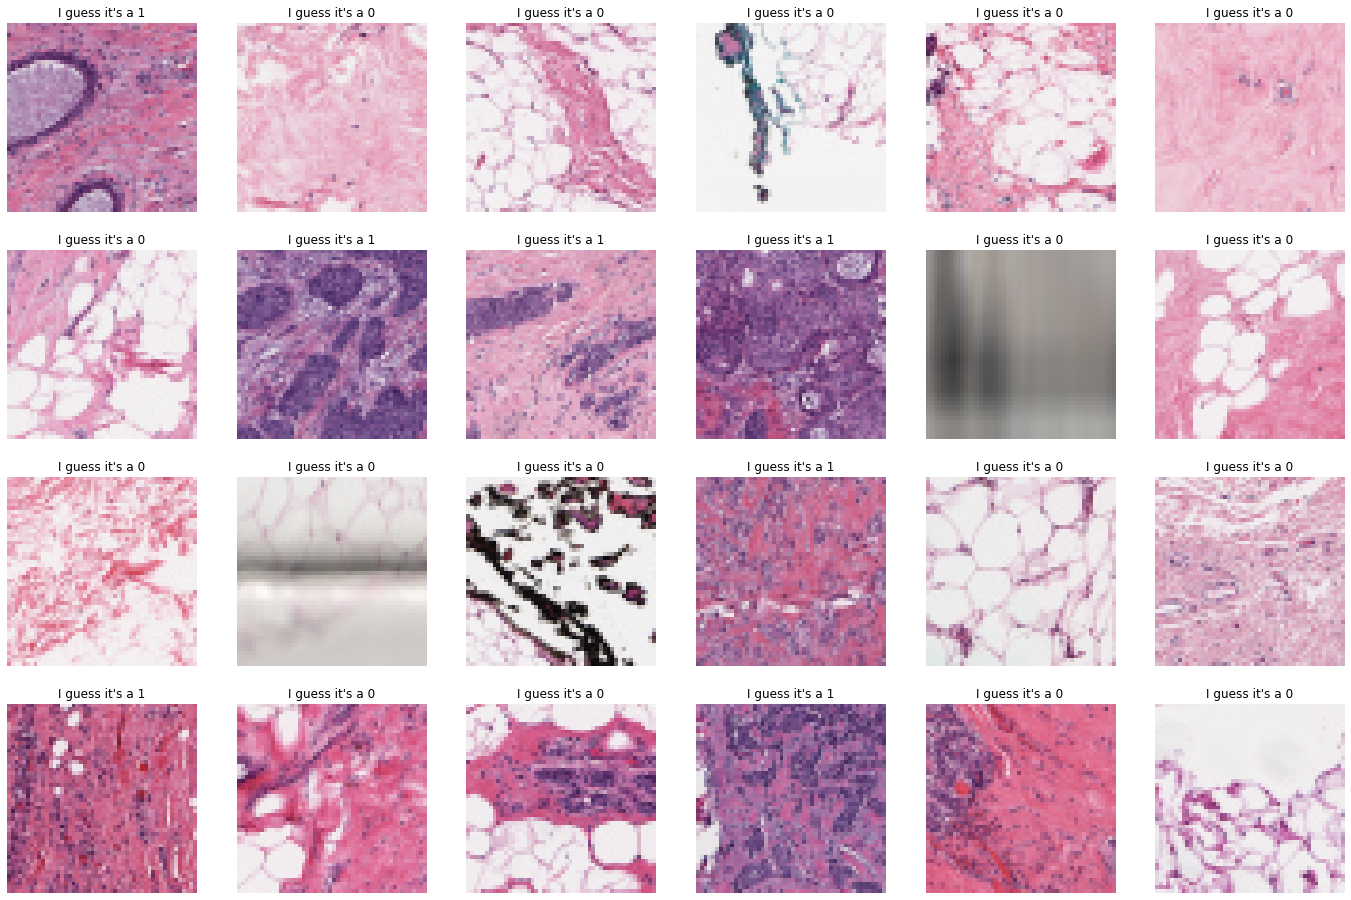

In [ ]:
samples, _ = iter(test_loader).next() 
samples = samples.to('cuda:0') 
fig = plt.figure(figsize=(24, 16)) 
fig.tight_layout() 
output = model(samples[:24]) 
pred = torch.argmax(output, dim=1) 
pred = [p.item() for p in pred] 
ad = {0:'I guess it\'s a 0', 1:'I guess it\'s a 1'} 
for num, sample in enumerate(samples[:24]): 
    plt.subplot(4,6,num+1) 
    plt.title(ad[pred[num]]) 
    plt.axis('off') 
    sample = sample.cpu().numpy() 
    plt.imshow(np.transpose(sample, (1,2,0))) 

Text(0.5, 1.0, 'test_loss')

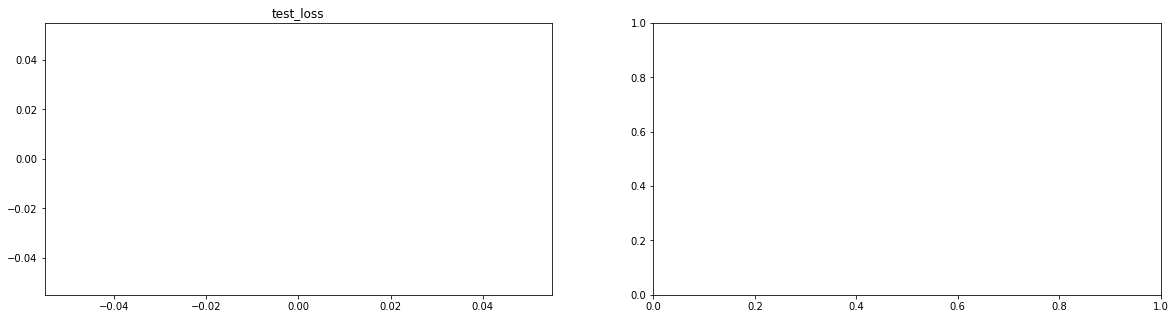

In [ ]:
import matplotlib.pyplot as plt 
figs , ax = plt.subplots(1,2,figsize=(20,5)) 
ax[0].plot(list_test_loss) 
ax[0].set_title('test_loss') 